In [49]:
module KldMclWorld

using Plots
using Distributions
using StatsBase
using LinearAlgebra
using Printf
using Logging
Logging.disable_logging(Logging.Info)

include("../scripts/mcl.jl")
import .MclWorld: RealRobot, RealCamera
import .MclWorld: IdealAgent, Agent, EstimationAgent, Landmark, Map, Camera, Robot, World
import .MclWorld: data, decision, state_transition, circle_shape, draw, append
import .MclWorld: Estimator, Particle, set_ml, motion_update, observation_update

mutable struct KldMcl <: Estimator
    init_pose::Array{Float64}
    max_num::Int64
    map::Map
    particles::Array{Particle}
    distance_dev_rate::Float64
    direction_dev::Float64
    motion_noise_rate_pdf::MvNormal
    ml::Particle
    pose::Array{Float64}
    widths::Array{Float64}
    epsilon::Float64
    delta::Float64
    binnum::Int64

    function KldMcl(
        init_pose,
        max_num;
        map=Map(),
        particles=[Particle(init_pose, 1.0)],
        distance_dev_rate=0.14,
        direction_dev=0.05,
        motion_noise_stds=Dict([("nn", 0.19), ("no", 0.001), ("on", 0.13), ("oo", 0.2)]),
        ml = particles[1],
        pose = ml.pose,
        widths=[0.2, 0.2, pi/18.0],
        epsilon=0.1,
        delta=0.01,
        binnum=0
        )
    
        c = diagm([motion_noise_stds["nn"]^2, motion_noise_stds["no"]^2, motion_noise_stds["on"]^2, motion_noise_stds["oo"]^2])
        motion_noise_rate_pdf = MvNormal([0, 0, 0, 0], c)
    
        new(
            init_pose,
            max_num,
            map,
            particles,
            distance_dev_rate,
            direction_dev,
            motion_noise_rate_pdf,
            ml,
            pose,
            widths,
            epsilon,
            delta,
            binnum
        )
    end

end

function resampling(self::KldMcl)
        
    ws = [e.weight for e in self.particles]
    if sum(ws) < 1e-100
        ws = [e + 1e-100 for e in ws]
    end   

    new_particles = []
    bins = Set()
    
    for i in 1:self.max_num
        chosen_p = sample(self.particles, Weights(ws), 1)
        p = chosen_p[1]
        push!(bins, [floor(e) for e in p.pose./self.widths])
        push!(new_particles, deepcopy(p))

        if length(bins) == 1
            self.binnum = 2
        else
            self.binnum = length(bins)
        end

        if length(new_particles) > ceil(quantile(Chisq(self.binnum-1), 1.0-self.delta)/(2*self.epsilon))
            break
        end
    end
            
    self.particles = [deepcopy(e) for e in new_particles]
    for p in self.particles
        p.weight = 1.0 / length(self.particles)
    end
    
end

function observation_update(self::KldMcl, observation)
    for p in self.particles
        observation_update(p, observation, self.map, self.distance_dev_rate, self.direction_dev)
    end
    set_ml(self)
    resampling(self)
end

function draw(self::KldMcl, plt)    
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    scale=0.5
    quiver!(plt, xs, ys, quiver=(scale*vxs, scale*vys), c=:orange)
    
    plot!(plt, annotation = (-2.5, -4.5, @sprintf("particles:%d, bin:%d", length(self.particles), self.binnum), :black))
end

end

Main.KldMclWorld

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_advanced_localization/tmp.gif")
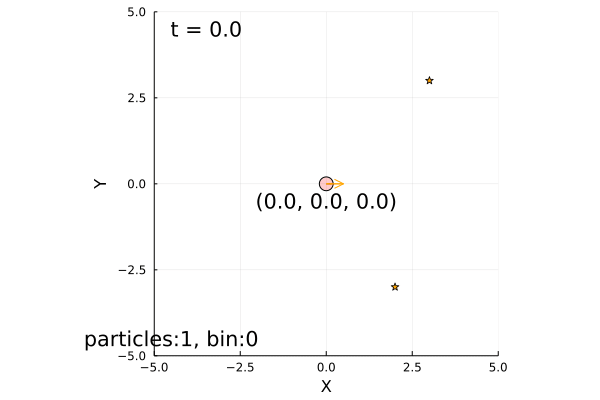

In [50]:
using .KldMclWorld

function trial()
    time_interval = 0.1    
    world = KldMclWorld.World(30, 0.1)

    ### 地図を生成して2つランドマークを追加 ###
    m = KldMclWorld.Map()
    KldMclWorld.append(m, KldMclWorld.Landmark([2, -3]))
    KldMclWorld.append(m, KldMclWorld.Landmark([3, 3]))
    KldMclWorld.append(world, m)
    
    initial_pose = [0, 0, 0]
    pf = KldMclWorld.KldMcl(initial_pose, 1000, map=m)
    a = KldMclWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, pf)
    r = KldMclWorld.RealRobot(initial_pose, :red, 0.2, a, sensor=KldMclWorld.RealCamera(m))
    KldMclWorld.append(world, r)

    KldMclWorld.draw(world)
end

trial()